In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
!pip install openpyxl
import warnings
warnings.filterwarnings("ignore")
import folium
import re

In [40]:
df = pd.read_csv("GTD RAND.csv", encoding="ISO-8859-1")

In [41]:
# Date Column to Datetime Farmat
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')

In [42]:
# Function to clean latitude and longitude values
def clean_coordinates(coord):
    # Remove non-numeric characters and determine sign
    if 'N' in coord or 'E' in coord:
        return float(coord.replace('° N', '').replace('° E', '').replace('°', ''))
    elif 'S' in coord or 'W' in coord:
        return -float(coord.replace('° S', '').replace('° W', '').replace('°', ''))
    else:
        return float(coord.replace('°', ''))


In [43]:
# Clean and convert the "longitude" and "latitude" columns
def clean_and_convert_coordinates(coord):
    # Ensure the coordinate is a string
    coord = str(coord)

    # Extract numeric parts from the coordinate string
    parts = re.findall(r"[-+]?\d*\.\d+|\d+", coord)

    if len(parts) >= 1:
        value = float(parts[0])

        # Handle directional indicators (N, S, E, W)
        if 'S' in coord or 'W' in coord:
            value = -value

        return value
    else:
        return None  # Return None for invalid coordinates

In [49]:
def clean_coordinates(coord):
    # Use regular expressions to extract numerical values and handle N/S/E/W
    match = re.search(r'([0-9.-]+)°?\s*([NSWE]?)', coord)
    if match:
        value, direction = match.groups()
        value = float(value)
        if direction in ('S', 'W'):
            value = -value
        return value
    return None


In [51]:
# Update Function that clean and convert co-ordinates

df['Latitude'] = df['latitude'].map(clean_and_convert_coordinates)
df['Longitude'] = df['longitude'].map(clean_and_convert_coordinates)

In [52]:
# Create a map centered at a specific location (e.g., a world map)
m = folium.Map(location=[-15.7801, -47.9292], zoom_start=4)

In [55]:
# Add markers for each incident
for _, row in df.dropna(subset=['Latitude', 'Longitude']).iterrows():
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=row['City']
    ).add_to(m)

# Display the map
m.save('terrorist_incidents_map.html')  # Save the map as an HTML file

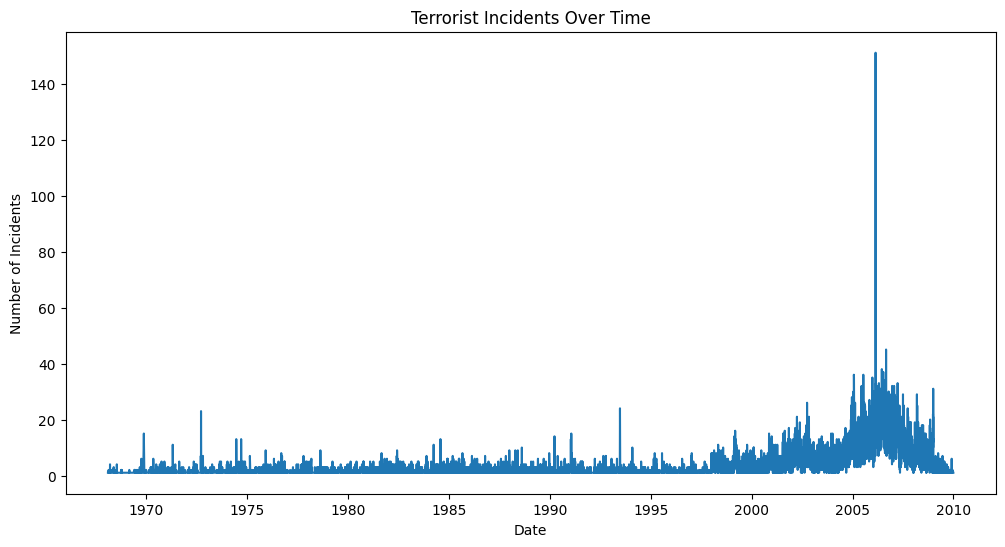

In [56]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Group incidents by date and count the number of incidents for each date
incidents_by_date = df.groupby('Date').size()

# Create a time series chart
plt.figure(figsize=(12, 6))
plt.plot(incidents_by_date.index, incidents_by_date.values)
plt.title('Terrorist Incidents Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Incidents')
plt.show()

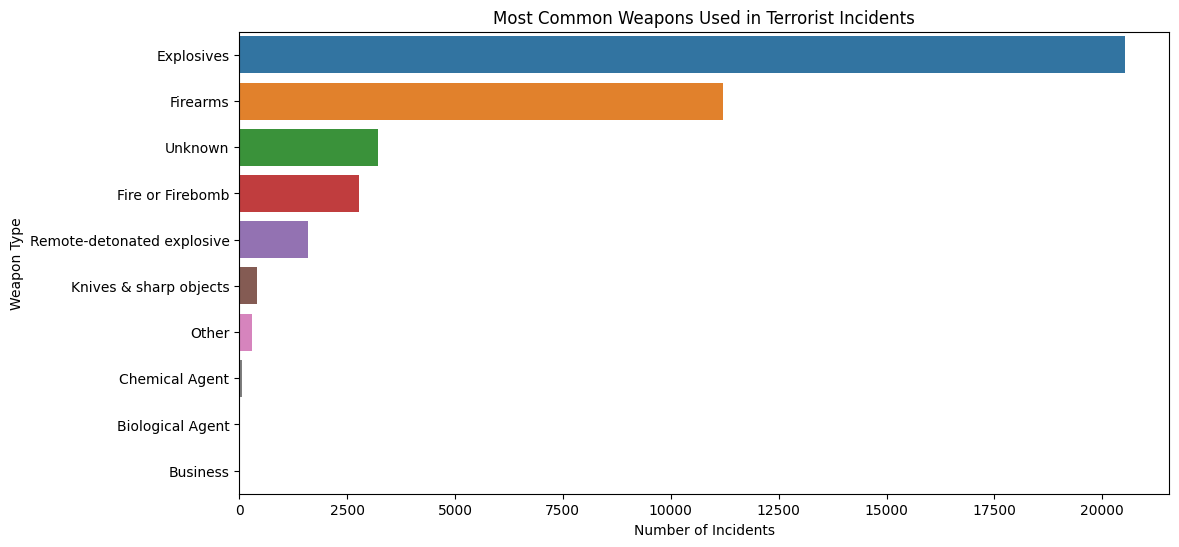

In [57]:
import seaborn as sns

# Group incidents by weapon type and count occurrences
weapons_counts = df['Weapon'].value_counts().head(10)

# Create a bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x=weapons_counts.values, y=weapons_counts.index, orient='h')
plt.title('Most Common Weapons Used in Terrorist Incidents')
plt.xlabel('Number of Incidents')
plt.ylabel('Weapon Type')
plt.show()


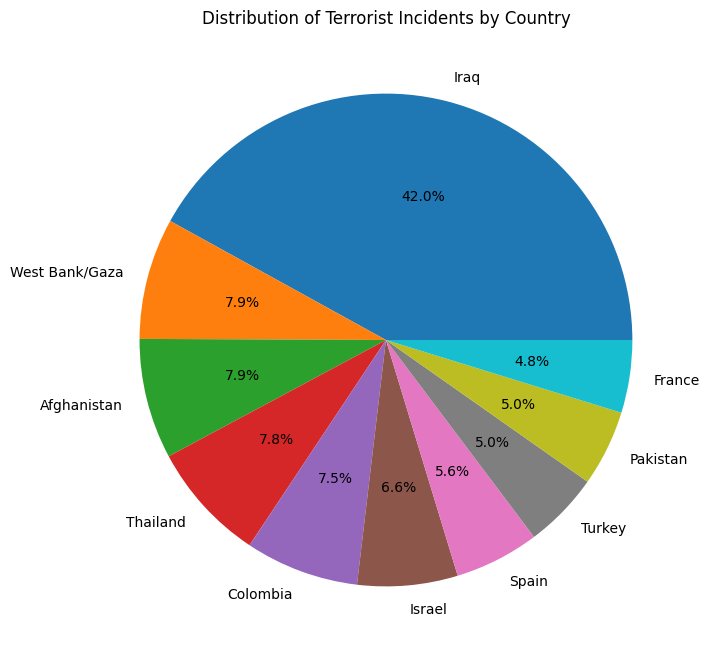

In [58]:
# Group incidents by country and count occurrences
country_counts = df['Country'].value_counts().head(10)

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(country_counts, labels=country_counts.index, autopct='%1.1f%%')
plt.title('Distribution of Terrorist Incidents by Country')
plt.show()


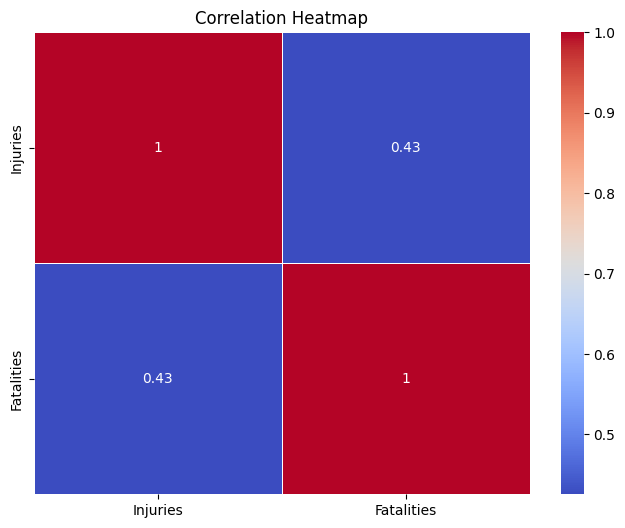

In [60]:
# Assuming you have additional columns for injuries, fatalities, and weapon types
correlation_matrix = df[['Injuries', 'Fatalities']].corr()

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()
